In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.decomposition import TruncatedSVD 

import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings(action = "ignore")

In [ ]:
! unzip /content/archive.zip

unzip:  cannot find or open /content/archive.zip, /content/archive.zip.zip or /content/archive.zip.ZIP.


In [ ]:
data  = pd.read_csv("/content/cumulative.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2294 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_pdisposition   9564 non-null   object 
 6   koi_score          8054 non-null   float64
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_period         9564 non-null   float64
 12  koi_period_err1    9110 non-null   float64
 13  koi_period_err2    9110 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0bk_err1   9110 non-null   float64
 16  koi_time0bk_err2   9110 

In [ ]:
data.isna().mean()

rowid                0.000000
kepid                0.000000
kepoi_name           0.000000
kepler_name          0.760142
koi_disposition      0.000000
koi_pdisposition     0.000000
koi_score            0.157884
koi_fpflag_nt        0.000000
koi_fpflag_ss        0.000000
koi_fpflag_co        0.000000
koi_fpflag_ec        0.000000
koi_period           0.000000
koi_period_err1      0.047470
koi_period_err2      0.047470
koi_time0bk          0.000000
koi_time0bk_err1     0.047470
koi_time0bk_err2     0.047470
koi_impact           0.037955
koi_impact_err1      0.047470
koi_impact_err2      0.047470
koi_duration         0.000000
koi_duration_err1    0.047470
koi_duration_err2    0.047470
koi_depth            0.037955
koi_depth_err1       0.047470
koi_depth_err2       0.047470
koi_prad             0.037955
koi_prad_err1        0.037955
koi_prad_err2        0.037955
koi_teq              0.037955
koi_teq_err1         1.000000
koi_teq_err2         1.000000
koi_insol            0.033563
koi_insol_

# Preprocessing

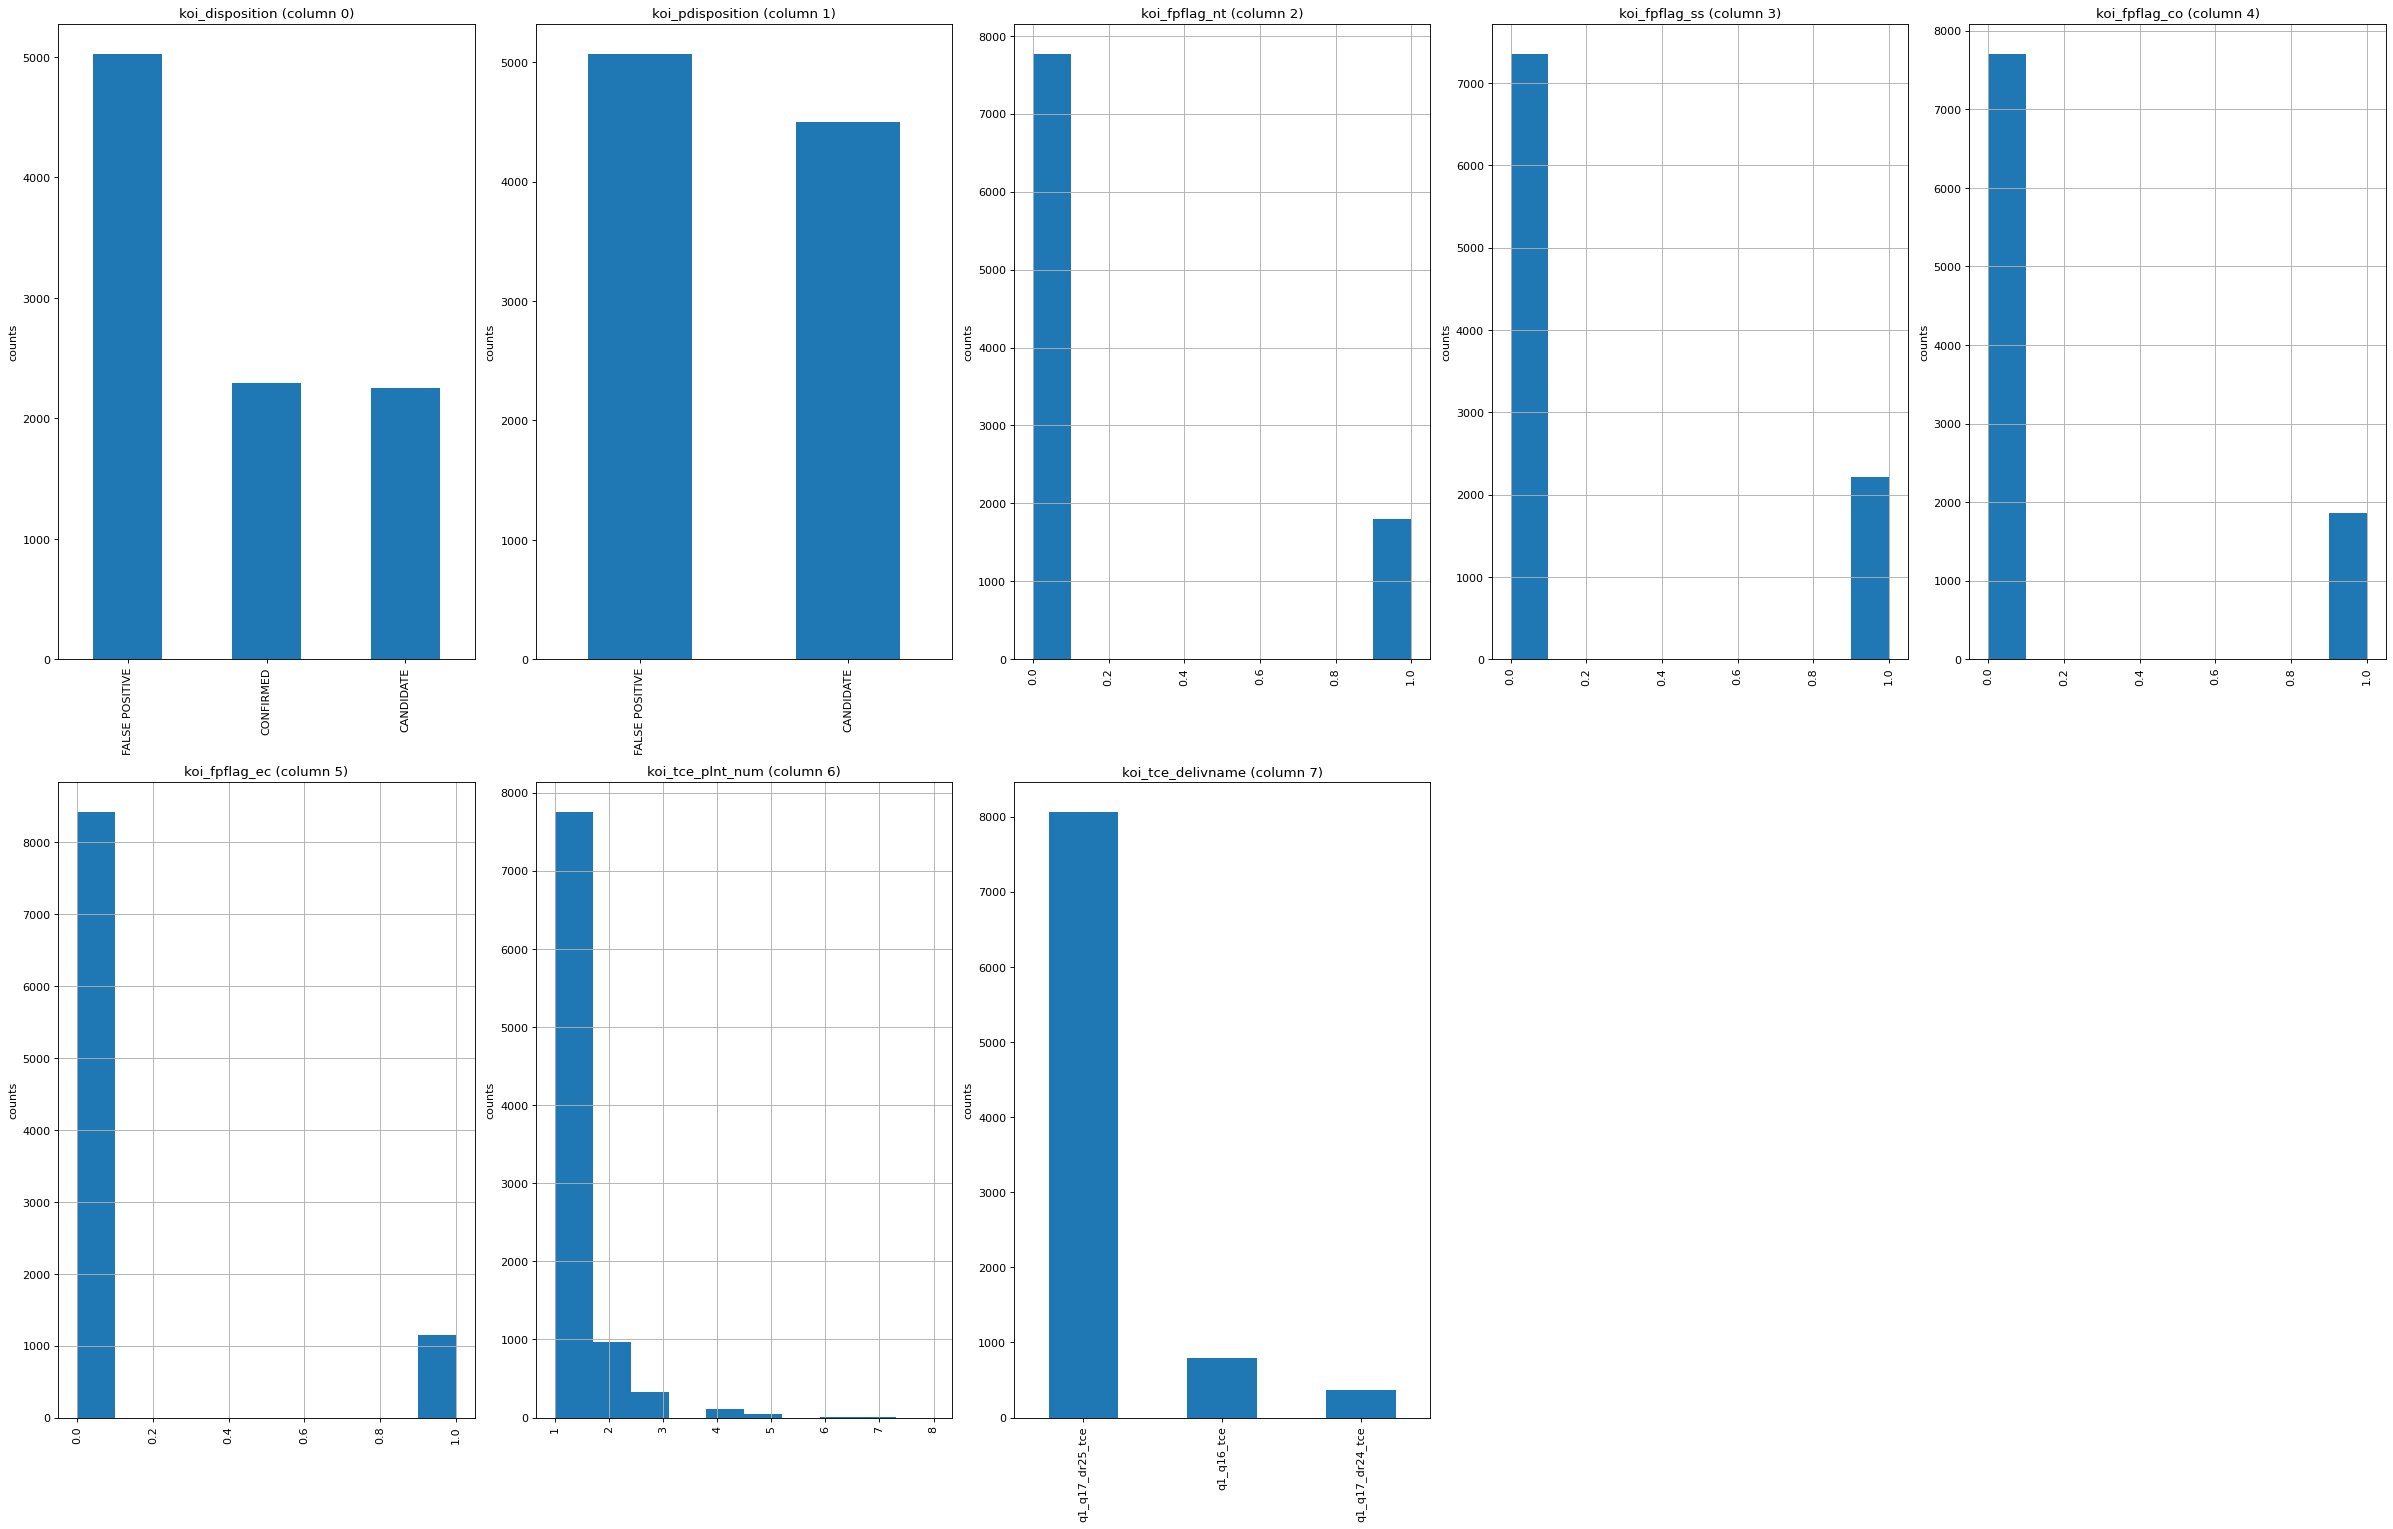

In [ ]:

# plt.plotPerColumnDistribution(X_train, 10, 5)
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
plotPerColumnDistribution(data, 20, 5)

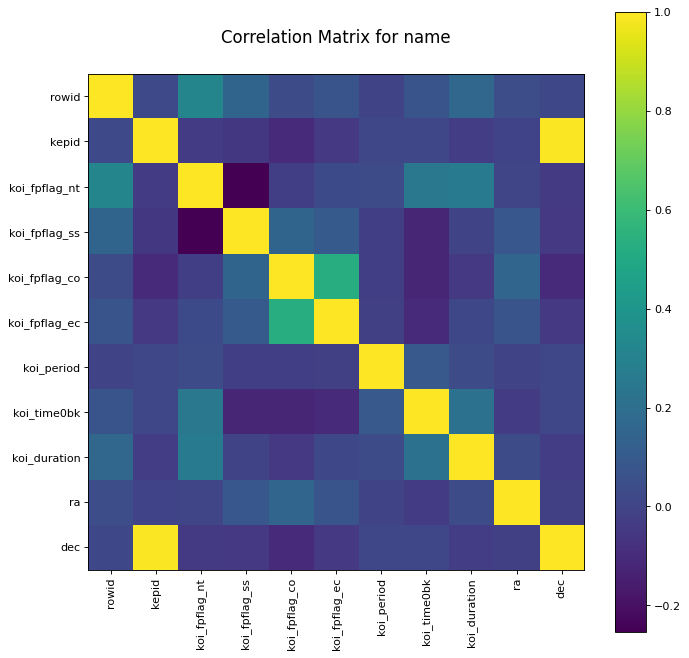

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()
data.dataframeName = "name"
plotCorrelationMatrix(data, 10)

In [ ]:
data["koi_disposition"].value_counts()

#we only try to predict CONFIRMED and FALSE POSITIVE.

FALSE POSITIVE    5023
CONFIRMED         2293
CANDIDATE         2248
Name: koi_disposition, dtype: int64

In [ ]:
data.isna().mean()
# koi_teq_err1 and koi_teq_err2 have 100% of missing value, so we drop them

rowid                0.000000
kepid                0.000000
kepoi_name           0.000000
kepler_name          0.760142
koi_disposition      0.000000
koi_pdisposition     0.000000
koi_score            0.157884
koi_fpflag_nt        0.000000
koi_fpflag_ss        0.000000
koi_fpflag_co        0.000000
koi_fpflag_ec        0.000000
koi_period           0.000000
koi_period_err1      0.047470
koi_period_err2      0.047470
koi_time0bk          0.000000
koi_time0bk_err1     0.047470
koi_time0bk_err2     0.047470
koi_impact           0.037955
koi_impact_err1      0.047470
koi_impact_err2      0.047470
koi_duration         0.000000
koi_duration_err1    0.047470
koi_duration_err2    0.047470
koi_depth            0.037955
koi_depth_err1       0.047470
koi_depth_err2       0.047470
koi_prad             0.037955
koi_prad_err1        0.037955
koi_prad_err2        0.037955
koi_teq              0.037955
koi_teq_err1         1.000000
koi_teq_err2         1.000000
koi_insol            0.033563
koi_insol_

#Preprocessing


In [ ]:
#Dropping categorical variables
data1 = data.drop(['rowid', "kepid", 'kepoi_name', 'kepler_name', 'koi_pdisposition'], axis = 1)

#ONE HOT ENCODING
# Fill remaining missing values
# use mode() to fill na with the most often value in the column
data1['koi_tce_delivname'] = data1['koi_tce_delivname'].fillna(data1['koi_tce_delivname'].mode()[0])

delivname = pd.get_dummies(data1['koi_tce_delivname'], prefix = "delivname")
data1 = pd.concat([data1, delivname], axis = 1)
data1 = data1.drop(['koi_tce_delivname'], axis = 1)


#dropping variables with too much null
data1 = data1.drop(['koi_teq_err2','koi_teq_err1','koi_score'], axis = 1)

In [ ]:
#SUPPORT FUNCTIONS
def fill_median(df,l):
  for col in l:
    med = df[col].quantile(0.5)
    if len(df[df[col].isna()])==0:
      continue
    else:
      df[col].fillna(med, inplace = True)
  
  return df


def confidence_interval(df,col_err1, col_err2, name_col):
  n = len(df.index)
  df[name_col] = abs(df[col_err1])+abs(df[col_err2])

  df = df.drop([col_err1, col_err2], axis = 1)
  return df

def all_intervals(df, l1):
  for err1 in l1:
    err2 = err1.replace('_err1','_err2')
    new_col = err1.split('_')[1]+'_interval'
    df = confidence_interval(df, err1,err2,new_col)
  return df

#size of the uncertainty interval with respect of the variable
def relative_col(df):
  for el in list(df):
    if '_interval' in el:
      x = el.replace('_interval','')
      y = el.replace('_interval','_relative')
      for el2 in list(df):
        if el == el2:
          continue
        if x in el2:
          df[y] = df[el]/df[el2]
          n = len(df.index)
          for i in range(n):
            if df[el2][i] == 0.0:
              df.at[i,y] = 0.0

      
  return df


In [ ]:
#SUPPORT LISTS
l = []
for el in list(data1):
  if '_err1' in el:
    x = el.replace('_err1','')
    for el2 in list(data1):
      if el2 == x:
        l.append(el2)


l1, l2 = [],[]
for el in list(data1):
  if '_err1' in el:
    l1.append(el)
    el2 = el.replace('_err1', '_err2')
    l2.append(el2)

m = ['koi_teq','koi_model_snr','koi_tce_plnt_num','koi_kepmag']

In [ ]:
data1 = fill_median(data1,l+l1+l2+m)
data2 = all_intervals(data1, l1)
data3 = relative_col(data2)
data3['insol_relative'].fillna(0.0, inplace = True)

In [ ]:
#storing the candidate dataset
candidates =data3[data3['koi_disposition']=='CANDIDATE']

In [ ]:
#removing the candidate
candidate_rows = data3.query("koi_disposition == 'CANDIDATE'").index
data4 = data3.drop(candidate_rows, axis = 0).reset_index(drop = True)

In [ ]:
#SCALING 
  # Split df into X and y
y_ = data4['koi_disposition']
X_ = data4.drop("koi_disposition", axis = 1)

  # Train Test set split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, train_size = 0.7, shuffle = True, random_state = 1)
  


  # Scale X
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
X_train = pd.DataFrame(X_train, index = X_train.index, columns = X_train.columns)
X_test = pd.DataFrame(X_test, index = X_test.index, columns = X_test.columns)

# Dimensionality Reduction

#### Performance evaluation functions

In [ ]:
def get_classifications(y_test, y_pred, positive_label = 'CONFIRMED'):
  tp = 0
  fn = 0
  fp = 0
  tn = 0

  for y_t, y_p in zip(y_test, y_pred):
    if y_t == positive_label:
      if y_p == positive_label:
        tp += 1
      else:
        fn += 1
    else:
      if y_p == positive_label:
        fp += 1
      else:
        tn += 1
  return tp, fn, fp, tn

def get_accuracy(tp, fn, fp, tn):
  acc= (tp + tn)/ (tp + fn + fp+ tn)
  return acc

def get_precision(tp, fn, fp, tn):
  precision = tp / (tp + fp)
  return precision

def get_recall(tp, fn, fp, tn):
  # out of all the actually positive value, what percentage we got right
  recall = tp/(tp + fn)
  return recall

def get_f1_score(tp, fn, fp, tn):
  precision = get_precision(tp, fn, fp, tn)
  recall = get_recall(tp, fn, fp, tn)
  # multiply 2, so the max value of f1 would be 1
  f1_score = (2 * precision * recall) / (precision + recall)
  return f1_score

## PCA


[0.14327666 0.11408541 0.08190722 0.06211392 0.05517553 0.04629391
 0.04153183 0.03425723 0.03057538 0.03010338 0.02632766 0.02560666
 0.02342251 0.02278624 0.02213022 0.0216954  0.02035982 0.01975308
 0.01905547 0.01803004]


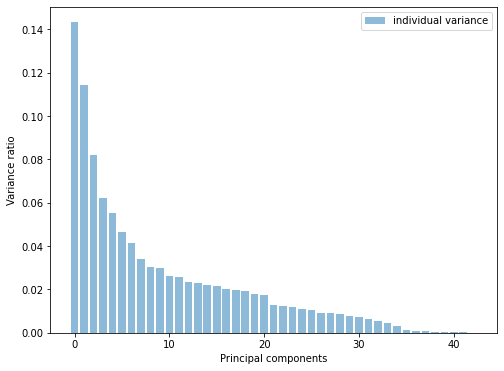

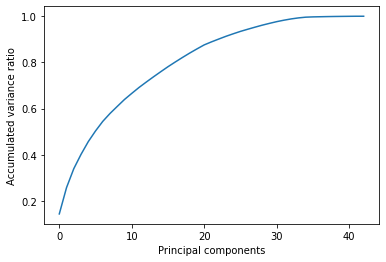

In [ ]:
# Visualize
pca = PCA()
pca.fit_transform(X_train)
pca_variance = pca.explained_variance_ratio_
print(pca.explained_variance_ratio_[0:20])
plt.figure(figsize=(8, 6))
plt.bar(range(len(X_train.columns)), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

ind = 0
sum = 0
sum_list = []
for i in pca_variance:
  ind += 1
  sum = sum + i
  sum_list.append(sum)
plt.plot(list(range(0,43)), sum_list)
plt.ylabel('Accumulated variance ratio')
plt.xlabel('Principal components')
plt.show()

In [ ]:
pca = PCA(n_components=26)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## SVD

### Testing all models with all number of components

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier


def get_models(model_choosed):
  models = dict()
  for i in range(1,43):
    steps = [('svd', TruncatedSVD(n_components=i)), ('m', model_choosed)]
    models[str(i)] = Pipeline(steps=steps)
  return models
  
# evaluate a give model using cross-validation
def evaluate_model(model, X_train, y_train):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
  return scores


In [ ]:
def train_evalute(model_choosed):
  # get the models to evaluate
  models = get_models(model_choosed)
  # evaluate the models and store results
  results, names = list(), list()
  for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
  # plot model performance for comparison
  plt.boxplot(results, labels=names, showmeans=True)
  plt.xticks(rotation=45)
  plt.show() 

In [ ]:
# training with SVD X_train
models = {
    "Decision Tree": DecisionTreeClassifier()
}

for name, model in models.items():
  print(name)
  train_evalute(model)
  print(name + " trained!")

Decision Tree
>1 0.698 (0.017)
>2 0.773 (0.016)
>3 0.838 (0.013)
>4 0.902 (0.015)
>5 0.929 (0.009)
>6 0.935 (0.010)
>7 0.935 (0.011)
>8 0.935 (0.009)
>9 0.935 (0.010)
>10 0.941 (0.011)
>11 0.940 (0.010)
>12 0.938 (0.011)
>13 0.938 (0.009)
>14 0.938 (0.011)
>15 0.936 (0.011)
>16 0.938 (0.010)
>17 0.935 (0.009)
>18 0.937 (0.012)
>19 0.938 (0.013)
>20 0.938 (0.011)
>21 0.939 (0.011)
>22 0.941 (0.011)
>23 0.939 (0.010)
>24 0.943 (0.009)
>25 0.941 (0.010)
>26 0.943 (0.010)
>27 0.943 (0.012)


KeyboardInterrupt: ignored

### Decided how many components to use and train all models with them


In [ ]:
# define the model
steps = [('svd', TruncatedSVD(n_components=21)), ('m', DecisionTreeClassifier())]
model = Pipeline(steps=steps)
# fit the model on the whole dataset
model.fit(X_train, y_train)
# make a single prediction
# row = [[0.2929949,-4.21223056,-1.288332,-2.17849815,-0.64527665,2.58097719,0.28422388,-7.1827928,-1.91211104,2.73729512,0.81395695,3.96973717,-2.66939799,3.34692332,4.19791821,0.99990998,-0.30201875,-4.43170633,-2.82646737,0.44916808]]

y_pred = model.predict(X_test)

print(name + " Accuracy: {:.3f}%".format(get_accuracy(*get_classifications(y_test, y_pred))*100))
print(name + " F1 Score: {:.3f}%".format(get_f1_score(*get_classifications(y_test, y_pred))*100))

# Training

## Setup

#### Imports

In [ ]:
# for models
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier



# for best param
from sklearn.model_selection import RandomizedSearchCV
from random import randint


# for performance testing 
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


#### Performance function

In [ ]:
def get_classifications(y_test, y_pred, positive_label = 'CONFIRMED'):
  tp = 0
  fn = 0
  fp = 0
  tn = 0

  for y_t, y_p in zip(y_test, y_pred):
    if y_t == positive_label:
      if y_p == positive_label:
        tp += 1
      else:
        fn += 1
    else:
      if y_p == positive_label:
        fp += 1
      else:
        tn += 1
  return tp, fn, fp, tn

def get_accuracy(tp, fn, fp, tn):
  acc= (tp + tn)/ (tp + fn + fp+ tn)
  return acc

def get_precision(tp, fn, fp, tn):
  precision = tp / (tp + fp)
  return precision

def get_recall(tp, fn, fp, tn):
  # out of all the actually positive value, what percentage we got right
  recall = tp/(tp + fn)
  return recall

def get_f1_score(tp, fn, fp, tn):
  precision = get_precision(tp, fn, fp, tn)
  recall = get_recall(tp, fn, fp, tn)
  # multiply 2, so the max value of f1 would be 1
  f1_score = (2 * precision * recall) / (precision + recall)
  return f1_score

#### Model function

In [ ]:
def run_model(X_train, y_train, X_test, y_test, model, params):
  res = dict()
  clf = model
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

  clf.fit(X_train, y_train)
  clf_score = clf.score(X_test, y_test)
  res["pre_score"] = clf_score
  n_scores = cross_val_score(clf, X_, y_, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
  res["cv_acc_avg"] = mean(n_scores)
  res["cv_acc_std"] = std(n_scores)

  y_pred = clf.predict(X_test)
  tp, fn, fp, tn = get_classifications(y_test, y_pred, positive_label = "CONFIRMED")
  res["house_pre_f1"] = get_f1_score(tp, fn, fp, tn)

  rs_clf = RandomizedSearchCV(clf, param_distributions=params, n_iter=5,n_jobs=-1,cv=5)
  rs_clf.fit(X_train, y_train)
  clf_cv = rs_clf.best_estimator_
  res["best_est"] = clf_cv

  clf_cv.fit(X_train, y_train)
  clf_score2 = clf_cv.score(X_test, y_test)
  res["post_score"] = clf_score2

  y_pred = clf_cv.predict(X_test)
  tp, fn, fp, tn = get_classifications(y_test, y_pred, positive_label = "CONFIRMED")
  res["house_post_f1"] = get_f1_score(tp, fn, fp, tn)
  
  n_scores = cross_val_score(clf_cv, X_, y_, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
  res["cv_acc_param_avg"] = mean(n_scores)
  res["cv_acc_param_std"] = std(n_scores)

  return res

## Classification Tree

### Quick 

In [ ]:
model = DecisionTreeClassifier()
params = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 10, 30, 50, 70, 100],
    "max_features": ['auto', 'sqrt', 'log2', None],
    "criterion": ["gini", "entropy"]
    }

In [ ]:
# normal dataset
res_ct = run_model(X_train, y_train, X_test, y_test, model, params)
res_ct

{'pre_score': 0.9722095671981776,
 'cv_acc_avg': 0.9812269042831263,
 'cv_acc_std': 0.006118506633391388,
 'house_pre_f1': 0.9545115585384041,
 'best_est': DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_split=50),
 'post_score': 0.9612756264236902,
 'house_post_f1': 0.9360421369450714,
 'cv_acc_param_avg': 0.9531164111342848,
 'cv_acc_param_std': 0.012799992483169306}

In [ ]:
# with PCA
res_pca_ct = run_model(X_train_pca, y_train, X_test_pca, y_test, model, params)
res_pca_ct

{'pre_score': 0.9394077448747152,
 'cv_acc_avg': 0.9818651122922165,
 'cv_acc_std': 0.005494538116407789,
 'house_pre_f1': 0.9021339220014717,
 'best_est': DecisionTreeClassifier(criterion='entropy', min_samples_split=30),
 'post_score': 0.9558086560364465,
 'house_post_f1': 0.9277736411020104,
 'cv_acc_param_avg': 0.9840973764013168,
 'cv_acc_param_std': 0.006361148394914121}

In [ ]:
steps = [('svd', TruncatedSVD(n_components=21)), ('m', model)]
model_svd = Pipeline(steps=steps)
params = {
    "m__max_depth": [3, 5, 10, None],
    "m__min_samples_split": [2, 10, 30, 50, 70, 100],
    "m__max_features": ['auto', 'sqrt', 'log2', None],
    "m__criterion": ["gini", "entropy"]
    }
res_svd_ct = run_model(X_train, y_train, X_test, y_test, model_svd, params)
res_svd_ct

{'pre_score': 0.9453302961275627,
 'cv_acc_avg': 0.8924707651519117,
 'cv_acc_std': 0.011190773184869132,
 'house_pre_f1': 0.9121522693997072,
 'best_est': Pipeline(steps=[('svd', TruncatedSVD(n_components=21)),
                 ('m',
                  DecisionTreeClassifier(max_features='auto',
                                         min_samples_split=70))]),
 'post_score': 0.9325740318906606,
 'house_post_f1': 0.8875379939209725,
 'cv_acc_param_avg': 0.8905121611486124,
 'cv_acc_param_std': 0.012716917047613137}

## RandomForest

#### Quick

In [ ]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
params = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [130, 180, 230]
    }

In [ ]:
# without
res_rf = run_model(X_train, y_train, X_test, y_test, rf, params)
print('Normal')
print(res_rf)
print('-------')
# with PCA
res_pca_rf = run_model(X_train_pca, y_train, X_test_pca, y_test, rf, params)
print('PCA')
print(res_pca_rf)
print('-------')
steps = [('svd', TruncatedSVD(n_components=21)), ('m', rf)]
model_svd = Pipeline(steps=steps)
params = {
    'm__bootstrap': [True, False],
    'm__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
    'm__max_features': ['auto', 'sqrt'],
    'm__min_samples_leaf': [1, 2, 4],
    'm__min_samples_split': [2, 5, 10],
    'm__n_estimators': [130, 180, 230]
    }
res_svd_rf = run_model(X_train, y_train, X_test, y_test, model_svd, params)
print('SVD')
print(res_svd_rf)
print('-------')

KeyboardInterrupt: ignored

## Naive Bayes

In [ ]:
rf = GaussianNB()
params = {
    'var_smoothing': np.logspace(-9, 1, 11)
    }

In [ ]:
# without
res_nb = run_model(X_train, y_train, X_test, y_test, rf, params)
print('Normal')
print(res_nb)
print('-------')
# with PCA
res_pca_nb = run_model(X_train_pca, y_train, X_test_pca, y_test, rf, params)
print('PCA')
print(res_pca_nb)
print('-------')
steps = [('svd', TruncatedSVD(n_components=21)), ('m', rf)]
model_svd = Pipeline(steps=steps)
params = {
    'm__var_smoothing': np.logspace(-9, 1, 11)
    }
res_svd_nb = run_model(X_train, y_train, X_test, y_test, model_svd, params)

print('SVD')
print(res_svd_nb)
print('-------')

Normal
{'pre_score': 0.95125284738041, 'cv_acc_avg': 0.6036107186552343, 'cv_acc_std': 0.01861636484998676, 'house_pre_f1': 0.9243816254416961, 'best_est': GaussianNB(var_smoothing=1e-08), 'post_score': 0.95125284738041, 'house_post_f1': 0.9243816254416961, 'cv_acc_param_avg': 0.5698032612460413, 'cv_acc_param_std': 0.018310919352239014}
-------
PCA
{'pre_score': 0.8214123006833713, 'cv_acc_avg': 0.6036107186552343, 'cv_acc_std': 0.01861636484998676, 'house_pre_f1': 0.7658303464755077, 'best_est': GaussianNB(var_smoothing=1e-07), 'post_score': 0.8214123006833713, 'house_post_f1': 0.7658303464755077, 'cv_acc_param_avg': 0.5472042190875588, 'cv_acc_param_std': 0.01580074374523469}
-------
SVD
{'pre_score': 0.7334851936218679, 'cv_acc_avg': 0.5796908444404576, 'cv_acc_std': 0.019159179480212448, 'house_pre_f1': 0.689655172413793, 'best_est': Pipeline(steps=[('svd', TruncatedSVD(n_components=21)),
                ('m', GaussianNB(var_smoothing=1e-08))]), 'post_score': 0.7334851936218679, '

## Multilayer Percepton

#### Quick

In [ ]:
rf = MLPClassifier()
params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
    }

In [ ]:
# without
res_mlp = run_model(X_train, y_train, X_test, y_test, rf, params)
print('Normal')
print(res_mlp)
print('-------')
# with PCA
res_pca_mlp = run_model(X_train_pca, y_train, X_test_pca, y_test, rf, params)
print('PCA')
print(res_pca_mlp)
print('-------')
# with SVD
steps = [('svd', TruncatedSVD(n_components=21)), ('m', rf)]
model_svd = Pipeline(steps=steps)
params = {
    'm__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'm__activation': ['tanh', 'relu'],
    'm__solver': ['sgd', 'adam'],
    'm__alpha': [0.0001, 0.05],
    'm__learning_rate': ['constant','adaptive']
    }
res_svd_mlp = run_model(X_train, y_train, X_test, y_test, model_svd, params)
print('SVD')
print(res_svd_mlp)
print('-------')

Normal
{'pre_score': 0.9886104783599089, 'cv_acc_avg': 0.914386311139019, 'cv_acc_std': 0.03182103248063647, 'house_pre_f1': 0.9812734082397004, 'best_est': MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(50, 100, 50)), 'post_score': 0.987243735763098, 'house_post_f1': 0.9790419161676647, 'cv_acc_param_avg': 0.8677286024334755, 'cv_acc_param_std': 0.02219427694585616}
-------
PCA
{'pre_score': 0.9854214123006834, 'cv_acc_avg': 0.917950869507798, 'cv_acc_std': 0.03298157415583888, 'house_pre_f1': 0.9761194029850746, 'best_est': MLPClassifier(alpha=0.05), 'post_score': 0.9849658314350798, 'house_post_f1': 0.9754281459419211, 'cv_acc_param_avg': 0.9139851340205674, 'cv_acc_param_std': 0.037021293738094534}
-------
SVD
{'pre_score': 0.9854214123006834, 'cv_acc_avg': 0.8583003794986034, 'cv_acc_std': 0.03833906224340417, 'house_pre_f1': 0.9762611275964392, 'best_est': Pipeline(steps=[('svd', TruncatedSVD(n_components=21)),
                ('m',
                 MLPClassifie

## Gradient Boosting

#### Quick

In [ ]:
rf = GradientBoostingClassifier()
params = {
    "learning_rate": [0.001, 0.01, 0.1],
    "min_samples_split": [50, 100],
    "min_samples_leaf": [50, 100],
    "max_depth":[5, 10, 20]
    }

In [ ]:
# without
res_gb = run_model(X_train, y_train, X_test, y_test, rf, params)
print('Normal')
print(res_gb)
print('-------')
# with PCA
res_pca_gb = run_model(X_train_pca, y_train, X_test_pca, y_test, rf, params)
print('PCA')
print(res_pca_gb)
print('-------')
# with SVD
steps = [('svd', TruncatedSVD(n_components=21)), ('m', rf)]
model_svd = Pipeline(steps=steps)
params = {
    "m__learning_rate": [0.001, 0.01, 0.1],
    "m__min_samples_split": [50, 100],
    "m__min_samples_leaf": [50, 100],
    "m__max_depth":[5, 10, 20]
    }
res_svd_gb = run_model(X_train, y_train, X_test, y_test, model_svd, params)
print('SVD')
print(res_svd_gb)
print('-------')

Normal
{'pre_score': 0.9936218678815489, 'cv_acc_avg': 0.9902028062464027, 'cv_acc_std': 0.004685999767654586, 'house_pre_f1': 0.9895522388059701, 'best_est': GradientBoostingClassifier(max_depth=5, min_samples_leaf=50,
                           min_samples_split=100), 'post_score': 0.9936218678815489, 'house_post_f1': 0.9895522388059701, 'cv_acc_param_avg': 0.9920262310032668, 'cv_acc_param_std': 0.003566794685247619}
-------
PCA
{'pre_score': 0.9776765375854214, 'cv_acc_avg': 0.9902028062464027, 'cv_acc_std': 0.004685999767654586, 'house_pre_f1': 0.9632958801498127, 'best_est': GradientBoostingClassifier(max_depth=5, min_samples_leaf=50,
                           min_samples_split=50), 'post_score': 0.9854214123006834, 'house_post_f1': 0.9760479041916168, 'cv_acc_param_avg': 0.9922081934819931, 'cv_acc_param_std': 0.0038542605721719595}
-------
SVD
{'pre_score': 0.9735763097949887, 'cv_acc_avg': 0.9305614735409986, 'cv_acc_std': 0.009310993508207079, 'house_pre_f1': 0.9565217391304

#### Decision Tree

In [ ]:
feature_names = X_train.columns.tolist()
print(X_train.shape, X_train_pca.shape)
feature_indices = np.abs(pca.components_).argmax(axis=1)
feature_indices

(5121, 43) (5121, 26)


array([42, 10, 16, 28,  2, 12, 40, 25, 14, 21, 35, 13, 27, 18, 37, 17, 40,
       35, 13, 36, 25,  0, 41, 19, 23,  2])

In [ ]:
print(feature_names)
transformed_feature_labels = [feature_names[i] for i in feature_indices]
len(transformed_feature_labels)

['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag', 'delivname_q1_q16_tce', 'delivname_q1_q17_dr24_tce', 'delivname_q1_q17_dr25_tce', 'period_interval', 'time0bk_interval', 'impact_interval', 'duration_interval', 'depth_interval', 'prad_interval', 'insol_interval', 'steff_interval', 'slogg_interval', 'srad_interval', 'period_relative', 'time0bk_relative', 'impact_relative', 'duration_relative', 'depth_relative', 'prad_relative', 'insol_relative', 'steff_relative', 'slogg_relative', 'srad_relative']


26

In [ ]:
print(res_pca_gb["best_est"].feature_importances_)
# Get the indices of the most important features
indices = np.argsort(res_pca_gb["best_est"].feature_importances_)[::-1]
model_gb_pca = res_pca_gb["best_est"]
# Print the feature names and importances
pca_features=[]
pca_importance = []
for i in indices:
  pca_features.append(feature_names[i])
  pca_importance.append(model_gb_pca.feature_importances_[i])
  #print(type(feature_names[i]))
  print(f"Feature {i}: {feature_names[i]} ({model_gb_pca.feature_importances_[i]:.3f})")



[3.13702713e-01 2.05559880e-02 1.18190964e-02 6.12629690e-03
 9.36766047e-02 4.15282207e-02 2.37654752e-01 3.10276234e-03
 5.59557794e-03 9.11488152e-02 2.64040632e-04 2.89288147e-02
 6.44567387e-04 1.01033823e-04 2.41921529e-03 1.36382330e-03
 1.51683949e-03 5.50147277e-03 3.25512702e-02 2.05971118e-03
 5.09768004e-03 3.52970863e-02 4.07001500e-03 2.34866573e-02
 1.41374215e-02 1.76495236e-02]
Feature 0: koi_fpflag_nt (0.314)
Feature 6: koi_impact (0.238)
Feature 4: koi_period (0.094)
Feature 9: koi_prad (0.091)
Feature 5: koi_time0bk (0.042)
Feature 21: delivname_q1_q17_dr24_tce (0.035)
Feature 18: dec (0.033)
Feature 11: koi_insol (0.029)
Feature 23: period_interval (0.023)
Feature 1: koi_fpflag_ss (0.021)
Feature 25: impact_interval (0.018)
Feature 24: time0bk_interval (0.014)
Feature 2: koi_fpflag_co (0.012)
Feature 3: koi_fpflag_ec (0.006)
Feature 8: koi_depth (0.006)
Feature 17: ra (0.006)
Feature 20: delivname_q1_q16_tce (0.005)
Feature 22: delivname_q1_q17_dr25_tce (0.004)
Fea

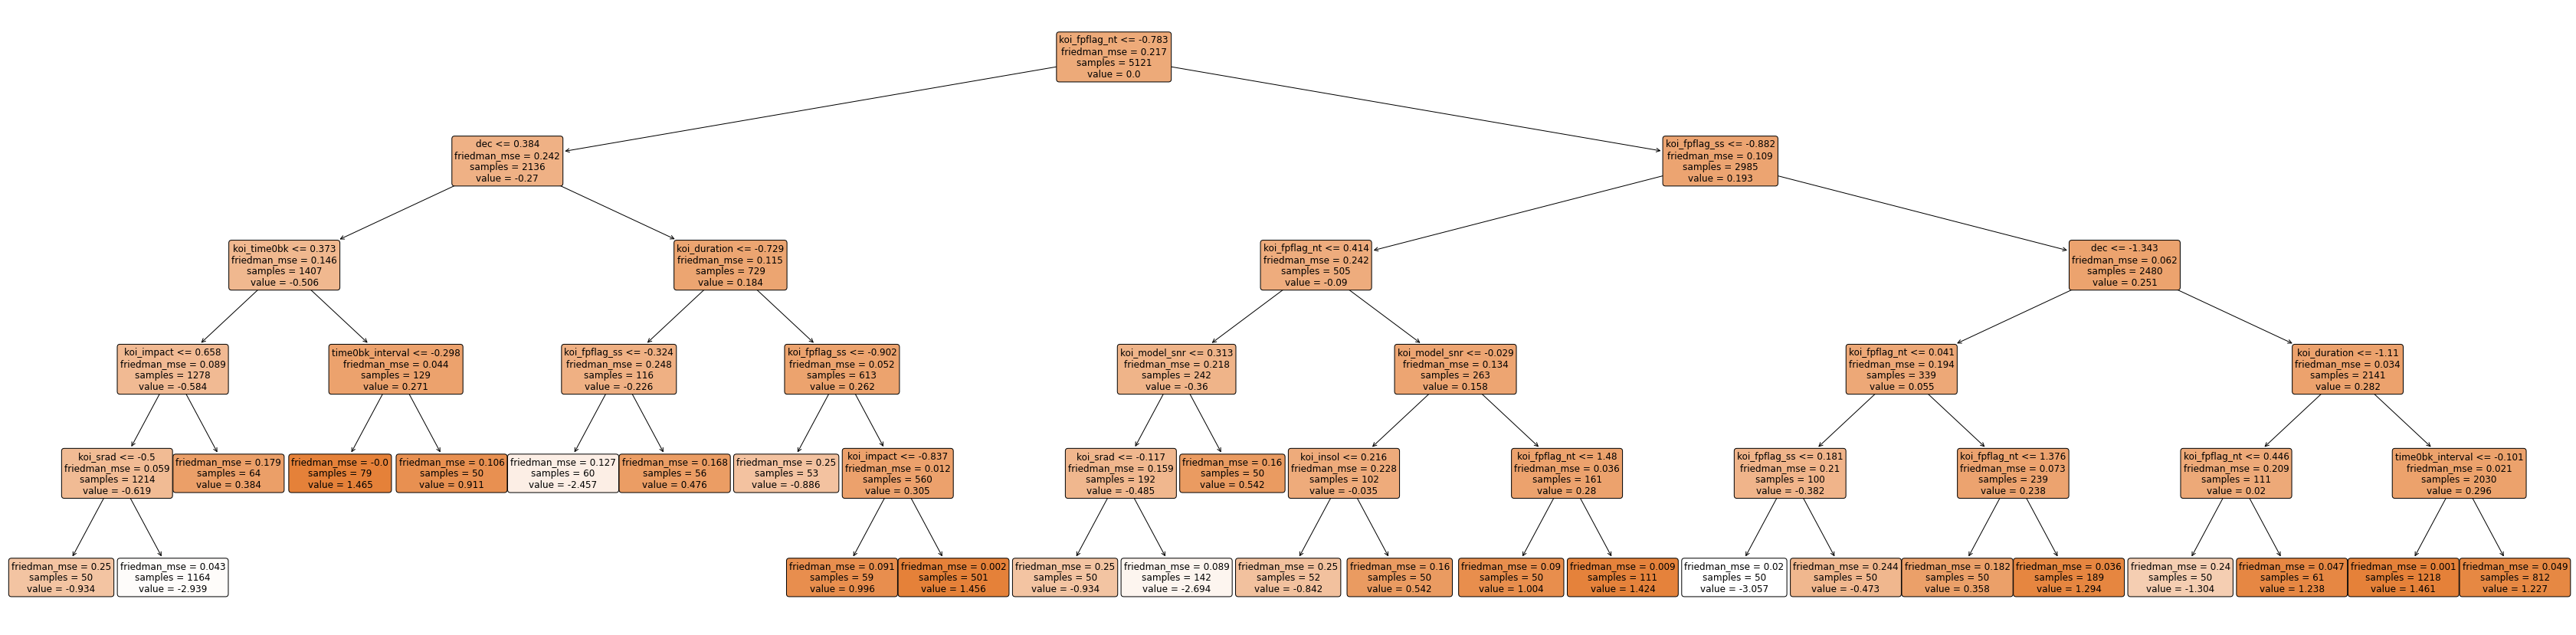

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
#gb_model = res_pca_gb["best_est"]
tree = res_pca_gb["best_est"].estimators_[0][0]
fig = plt.figure(figsize=(60, 15))
plot_tree(tree, filled=True, rounded=True, class_names=["positive", "negative"], fontsize=12, feature_names= pca_features)
plt.show()

#### Feature importance

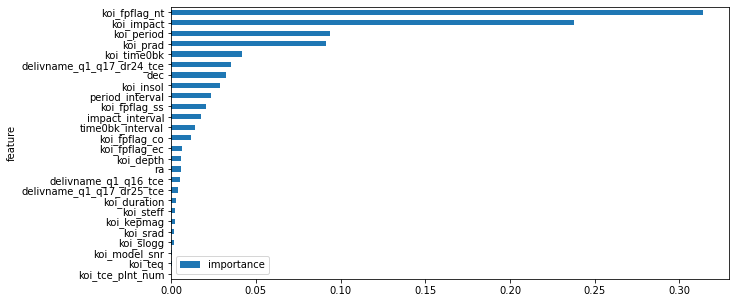

In [ ]:
gb_importance = pd.DataFrame({'feature': pca_features, 'importance': pca_importance})
gb_importance = gb_importance.sort_values(by='importance', ascending=True)
gb_importance.plot(x='feature', y='importance', kind='barh', figsize=(10, 5))
plt.show()

In [ ]:
print(sorted(pca_features))
print(sorted(transformed_feature_labels))

['dec', 'delivname_q1_q16_tce', 'delivname_q1_q17_dr24_tce', 'delivname_q1_q17_dr25_tce', 'impact_interval', 'koi_depth', 'koi_duration', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_impact', 'koi_insol', 'koi_kepmag', 'koi_model_snr', 'koi_period', 'koi_prad', 'koi_slogg', 'koi_srad', 'koi_steff', 'koi_tce_plnt_num', 'koi_teq', 'koi_time0bk', 'period_interval', 'ra', 'time0bk_interval']
['dec', 'delivname_q1_q17_dr24_tce', 'depth_interval', 'depth_relative', 'duration_relative', 'impact_interval', 'impact_interval', 'impact_relative', 'impact_relative', 'koi_fpflag_co', 'koi_fpflag_co', 'koi_fpflag_nt', 'koi_kepmag', 'koi_model_snr', 'koi_srad', 'koi_steff', 'koi_tce_plnt_num', 'koi_tce_plnt_num', 'koi_teq', 'period_interval', 'prad_interval', 'ra', 'slogg_relative', 'srad_relative', 'steff_relative', 'steff_relative']


## XGBoost

#### Quick

In [ ]:
rf = XGBClassifier()
params = {
    'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
    'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight' : [ 1, 3, 5, 7 ],
    'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
    }

In [ ]:
# without
res_xg = run_model(X_train, y_train, X_test, y_test, rf, params)
print('Normal')
print(res_xg)
print('-------')
# with PCA
res_pca_xg = run_model(X_train_pca, y_train, X_test_pca, y_test, rf, params)
print('PCA')
print(res_pca_xg)
print('-------')
# with SVD
steps = [('svd', TruncatedSVD(n_components=21)), ('m', rf)]
model_svd = Pipeline(steps=steps)
params = {
    'm__learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
    'm__max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
    'm__min_child_weight' : [ 1, 3, 5, 7 ],
    'm__gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    'm__colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
    }
res_svd_xg = run_model(X_train, y_train, X_test, y_test, model_svd, params)
print('SVD')
print(res_svd_xg)
print('-------')

Normal
{'pre_score': 0.992255125284738, 'cv_acc_avg': 0.9902028062464024, 'cv_acc_std': 0.004134735183339024, 'house_pre_f1': 0.9872659176029962, 'best_est': XGBClassifier(colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=15), 'post_score': 0.9940774487471526, 'house_post_f1': 0.9902475618904727, 'cv_acc_param_avg': 0.9912964499562692, 'cv_acc_param_std': 0.003955195104734384}
-------
PCA
{'pre_score': 0.9776765375854214, 'cv_acc_avg': 0.9902028062464024, 'cv_acc_std': 0.004134735183339024, 'house_pre_f1': 0.9633507853403142, 'best_est': XGBClassifier(m__colsample_bytree=0.7, m__gamma=0.1, m__learning_rate=0.2,
              m__max_depth=6, m__min_child_weight=3), 'post_score': 0.9776765375854214, 'house_post_f1': 0.9633507853403142, 'cv_acc_param_avg': 0.9902028062464024, 'cv_acc_param_std': 0.004134735183339024}
-------
SVD
{'pre_score': 0.9749430523917996, 'cv_acc_avg': 0.9319287773566663, 'cv_acc_std': 0.009254745202211439, 'house_pre_f1': 0.958924570575056, 'best_est'

## KNN

#### Quick

In [ ]:
rf = KNeighborsClassifier(n_neighbors=5)
params = {
    'n_neighbors': range(1, 20),
    'weights': ['uniform', 'distance']
    }

In [ ]:
# without
res_knn = run_model(X_train, y_train, X_test, y_test, rf, params)
print('Normal')
print(res_knn)
print('-------')
# with PCA
res_pca_knn = run_model(X_train_pca, y_train, X_test_pca, y_test, rf, params)
print('PCA')
print(res_pca_knn)
print('-------')
# with SVD
steps = [('svd', TruncatedSVD(n_components=21)), ('m', rf)]
model_svd = Pipeline(steps=steps)
params = {
    'm__n_neighbors': range(1, 20),
    'm__weights': ['uniform', 'distance']
}
res_svd_knn = run_model(X_train, y_train, X_test, y_test, model_svd, params)
print('SVD')
print(res_svd_knn)
print('-------')

Normal
{'pre_score': 0.9735763097949887, 'cv_acc_avg': 0.8585280039071161, 'cv_acc_std': 0.01106318991115486, 'house_pre_f1': 0.9575402635431918, 'best_est': KNeighborsClassifier(n_neighbors=3), 'post_score': 0.9790432801822323, 'house_post_f1': 0.9661266568483063, 'cv_acc_param_avg': 0.8562967365113537, 'cv_acc_param_std': 0.012516430415539551}
-------
PCA
{'pre_score': 0.973120728929385, 'cv_acc_avg': 0.8585280039071161, 'cv_acc_std': 0.01106318991115486, 'house_pre_f1': 0.9569657184536835, 'best_est': KNeighborsClassifier(n_neighbors=3, weights='distance'), 'post_score': 0.9758542141230069, 'house_post_f1': 0.9611151870873075, 'cv_acc_param_avg': 0.8553400785908468, 'cv_acc_param_std': 0.012356327705853659}
-------
SVD
{'pre_score': 0.9671981776765376, 'cv_acc_avg': 0.8584824665664968, 'cv_acc_std': 0.01111326746729423, 'house_pre_f1': 0.9479015918958031, 'best_est': Pipeline(steps=[('svd', TruncatedSVD(n_components=21)),
                ('m', KNeighborsClassifier(n_neighbors=7, wei

## Light GBM

In [ ]:
rf = LGBMClassifier()
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7]
    }

In [ ]:
# without
res_lgbm = run_model(X_train, y_train, X_test, y_test, rf, params)
print('Normal')
print(res_lgbm)
print('-------')
# with PCA
res_pca_lgbm = run_model(X_train_pca, y_train, X_test_pca, y_test, rf, params)
print('PCA')
print(res_pca_lgbm)
print('-------')
# with SVD
steps = [('svd', TruncatedSVD(n_components=21)), ('m', rf)]
model_svd = Pipeline(steps=steps)
params = {
    'm__learning_rate': [0.1, 0.01, 0.001],
    'm__n_estimators': [100, 500, 1000],
    'm__max_depth': [3, 5, 7]
    }
res_svd_lgbm = run_model(X_train, y_train, X_test, y_test, model_svd, params)
print('SVD')
print(res_svd_lgbm)
print('-------')

Normal
{'pre_score': 0.9936218678815489, 'cv_acc_avg': 0.9909318397583967, 'cv_acc_std': 0.00431775365225701, 'house_pre_f1': 0.9895366218236173, 'best_est': LGBMClassifier(m__n_neighbors=5, m__weights='distance'), 'post_score': 0.9936218678815489, 'house_post_f1': 0.9895366218236173, 'cv_acc_param_avg': 0.9909318397583967, 'cv_acc_param_std': 0.00431775365225701}
-------
PCA
{'pre_score': 0.9876993166287016, 'cv_acc_avg': 0.9909318397583967, 'cv_acc_std': 0.00431775365225701, 'house_pre_f1': 0.9797752808988764, 'best_est': LGBMClassifier(m__n_neighbors=14, m__weights='distance'), 'post_score': 0.9876993166287016, 'house_post_f1': 0.9797752808988764, 'cv_acc_param_avg': 0.9909318397583967, 'cv_acc_param_std': 0.00431775365225701}
-------
SVD
{'pre_score': 0.9822323462414578, 'cv_acc_avg': 0.9411781525419927, 'cv_acc_std': 0.008632086346474265, 'house_pre_f1': 0.9708302169035153, 'best_est': Pipeline(steps=[('svd', TruncatedSVD(n_components=21)),
                ('m', LGBMClassifier(max

## Catboost

In [ ]:
rf = CatBoostClassifier(verbose = 0)
params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5]
    }

In [ ]:
# without
res_cb = run_model(X_train, y_train, X_test, y_test, rf, params)
print('Normal')
print(res_cb)
print('-------')
# with PCA
res_pca_cb = run_model(X_train_pca, y_train, X_test_pca, y_test, rf, params)
print('PCA')
print(res_pca_cb)
print('-------')
# with SVD
steps = [('svd', TruncatedSVD(n_components=21)), ('m', rf)]
model_svd = Pipeline(steps=steps)
params = {
    'm__learning_rate': [0.1, 0.01, 0.001],
    'm__n_estimators': [100, 500, 1000],
    'm__depth': [3, 5, 7],
    'm__l2_leaf_reg': [1, 3, 5]
    }
res_svd_cb = run_model(X_train, y_train, X_test, y_test, model_svd, params)
print('SVD')
print(res_svd_cb)
print('-------')

Normal
{'pre_score': 0.9945330296127562, 'cv_acc_avg': 0.9921622823738723, 'cv_acc_std': 0.0037028104762783457, 'house_pre_f1': 0.9910179640718563, 'best_est': <catboost.core.CatBoostClassifier object at 0x7f4341131880>, 'post_score': 0.99498861047836, 'house_post_f1': 0.9917602996254681, 'cv_acc_param_avg': 0.9916155228135224, 'cv_acc_param_std': 0.003911785589720153}
-------
PCA
{'pre_score': 0.9835990888382687, 'cv_acc_avg': 0.9921622823738723, 'cv_acc_std': 0.0037028104762783457, 'house_pre_f1': 0.9731743666169895, 'best_est': <catboost.core.CatBoostClassifier object at 0x7f4347a22550>, 'post_score': 0.9849658314350798, 'house_post_f1': 0.9752808988764046, 'cv_acc_param_avg': 0.9914787239079137, 'cv_acc_param_std': 0.0037653685866570383}
-------
SVD
{'pre_score': 0.9822323462414578, 'cv_acc_avg': 0.9421341252220803, 'cv_acc_std': 0.007460253452640681, 'house_pre_f1': 0.9708302169035153, 'best_est': Pipeline(steps=[('svd', TruncatedSVD(n_components=21)),
                ('m',
      

In [ ]:
#res_pca["best_est"].get_params()

{'learning_rate': 0.1,
 'depth': 3,
 'l2_leaf_reg': 1,
 'verbose': 0,
 'n_estimators': 500}

# Results

In [ ]:
# we perform PCA on the candidate set, keeping 26 components
candidates = candidates.drop('koi_disposition', axis=1)
candidate_pca = pca.fit_transform(candidates)

In [ ]:
model_gb_pca = res_pca_gb["best_est"]
y_pred =  model_gb_pca.predict(candidate_pca)
y_pred

array(['FALSE POSITIVE', 'FALSE POSITIVE', 'FALSE POSITIVE', ...,
       'FALSE POSITIVE', 'FALSE POSITIVE', 'FALSE POSITIVE'], dtype=object)

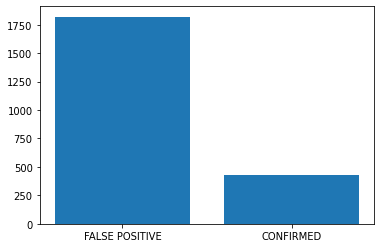

In [ ]:
from collections import Counter
# Count the occurrences of each value
counts = Counter(y_pred)
# Get the values and their counts
x, y = zip(*counts.items())

# Plot a bar chart
plt.bar(x, y)
plt.show()